# Airline Satisfaction - Classification

The following dataframe was imported from kaggle.com. It presents reviews of a certain airline made by close to 130 thousand people. Each person is identified by his/her ID number followed by some identifying features of the person and the type of flight and the review of said person in several different categories (explained further down in the notebook). The review system is to give a 0–5-star rating for each category. This is followed by a concluding column of whether the person was overall "satisfied" with the airline and the flight or was "neutral or dissatisfied".<br>
Link to the dataset on kaggle: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction<br><br>

Our purpose in this notebook is to determine whether a passenger was satisfied with the airline or not (in other words: which of the 2 possible answers the passenger would choose: "satisfied" or "neutral or dissatisfied").

In [1]:
#Importing the libraries used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings
import time
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

We next must import the dataframe into the notebook. The dataframe was divided on kaggle.com to the train and test set. We shall first combine the 2 dataframes into a single one so as not to apply all changes to both dataframes (to be divided later on in the notebook back into the train and test set, although not necessarily the same ones as on download).<br>
Henceforth, we shall refer to the whole dataset "fulldf" instead of the train and test sets imported to the notebook (until it is again divided).

In [2]:
defaultTest = pd.read_csv('Data/Airline Satisfaction/Import/test.csv') #importing the dataframe 'test.csv' from the appropriate folder
defaultTrain = pd.read_csv('Data/Airline Satisfaction/Import/train.csv') #importing the dataframe 'train.csv' from the appropriate folder
fulldf = pd.concat([defaultTest, defaultTrain]) #merging  the 2 datasets, so that we can work as if we were given the undivided
#dataset in the first place.
fulldf.index.name = 'i' #renaming the index column so that the new index will not have the same name as the old
fulldf = fulldf.reset_index() #Resetting the indexes for appearance's sake.
fulldf = fulldf.drop(['i', 'Unnamed: 0'], axis = 1) #removing the columns of indexes which we changed: the change was not
#necessary, only for the sake of appearance
fulldf

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
129876,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
129877,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
129878,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [3]:
fulldf.groupby(['Class', 'Gender']).count()['id']

Class     Gender
Business  Female    31263
          Male      30897
Eco       Female    29670
          Male      28639
Eco Plus  Female     4966
          Male       4445
Name: id, dtype: int64

## Data Cleaning

Before delving into the data cleaning, we first must understand what it is that we must do. To do that, we first check whether there are any duplicates in the data provided. Because all reviewer have a unique ID, it is enough to check whether there are 2 reviews (2 records in the dataset) with the same ID. To do that, we group the dataset by ID using groupby() and check if the size of any of the groups provided is greater than 1 (as we can see below). From this we can gather that no duplicate IDs exist, hence there are no duplicate reviews in the dataset.

In [4]:
dupl = fulldf.groupby(['id']).size()>1
dupl.value_counts()
#Checking that there are no duplicates (no values that are true)

False    129880
Name: count, dtype: int64

After checking the dataset for duplicates, we no longer need the ID attribute, as it is of no use in predicting the overall satisfaction of the reviewer.

In [5]:
fulldf = fulldf.drop(['id'], axis = 1) #Further unneeded attribute

Below, we can see the name of every attribute, the count of non-null values for each attribute and the type of data each attribute has. Keeping in mind that the dataset has 129880 records, we can derive that the only attribute that has NaN values is "Arrival Delay in Minutes". We will have to deal with those. Further on, as seen below, there are several attributes where the type of data is "object". From a quick review of the dataset, we can see that it is a string, which for the purposes of machine learning we shall have to encode as numerical values.

In [6]:
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

To encode the attributes with strings we first must understand what kinds of strings each attribute presents. From the code below we can see that every attribute with strings, has only a small number of possible values, for example: the attribute "Gender" has only 2 possible values: "Male" and "Female". All other values for attributes can be seen below, with the number of values of each value for each attribute.

In [7]:
print('Gender:\n', fulldf['Gender'].value_counts(), '\n')
print('Customer Type:\n', fulldf['Customer Type'].value_counts(), '\n')
print('Type of Travel:\n', fulldf['Type of Travel'].value_counts(), '\n')
print('Class:\n', fulldf['Class'].value_counts(), '\n')
print('satisfaction:\n', fulldf['satisfaction'].value_counts(), '\n')

Gender:
 Gender
Female    65899
Male      63981
Name: count, dtype: int64 

Customer Type:
 Customer Type
Loyal Customer       106100
disloyal Customer     23780
Name: count, dtype: int64 

Type of Travel:
 Type of Travel
Business travel    89693
Personal Travel    40187
Name: count, dtype: int64 

Class:
 Class
Business    62160
Eco         58309
Eco Plus     9411
Name: count, dtype: int64 

satisfaction:
 satisfaction
neutral or dissatisfied    73452
satisfied                  56428
Name: count, dtype: int64 



Now that we know what each "object" attribute consists of (in terms of values), we can encode them.

In [8]:
#Encoding values from string to numerical

fulldf['Gender'] = fulldf['Gender'].replace({"Male": 0, "Female": 1})
fulldf['satisfaction'] = fulldf['satisfaction'].replace({"neutral or dissatisfied": 0, "satisfied": 1})
fulldf['Type of Travel'] = fulldf['Type of Travel'].replace({"Personal Travel": 0, "Business travel": 1})
fulldf['Customer Type'] = fulldf['Customer Type'].replace({"disloyal Customer": 0, "Loyal Customer": 1})
fulldf['Class'] = fulldf['Class'].replace({"Eco": 0, "Eco Plus": 1, "Business": 2})
fulldf

C:\Users\appel\AppData\Local\Temp\ipykernel_3876\1903970216.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fulldf['Gender'] = fulldf['Gender'].replace({"Male": 0, "Female": 1})
C:\Users\appel\AppData\Local\Temp\ipykernel_3876\1903970216.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fulldf['satisfaction'] = fulldf['satisfaction'].replace({"neutral or dissatisfied": 0, "satisfied": 1})
C:\Users\appel\AppData\Local\Temp\ipykernel_3876\1903970216.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will 

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,52,1,0,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,1,1,36,1,2,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,0,0,20,1,0,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,0,1,44,1,2,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,1,1,49,1,0,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,0,23,1,0,192,2,1,2,3,...,2,3,1,4,2,3,2,3,0.0,0
129876,0,1,49,1,2,2347,4,4,4,4,...,5,5,5,5,5,5,4,0,0.0,1
129877,0,0,30,1,2,1995,1,1,1,3,...,4,3,2,4,5,5,4,7,14.0,0
129878,1,0,22,1,0,1000,1,1,1,5,...,1,4,5,1,5,4,1,0,0.0,0


Below are the histograms of every attribute and the with the attribute values as the x-axis and the number of records with said value in said attribute as the y-axis. For our purposes, its main purpose is to visualize the data and understand it slightly better.

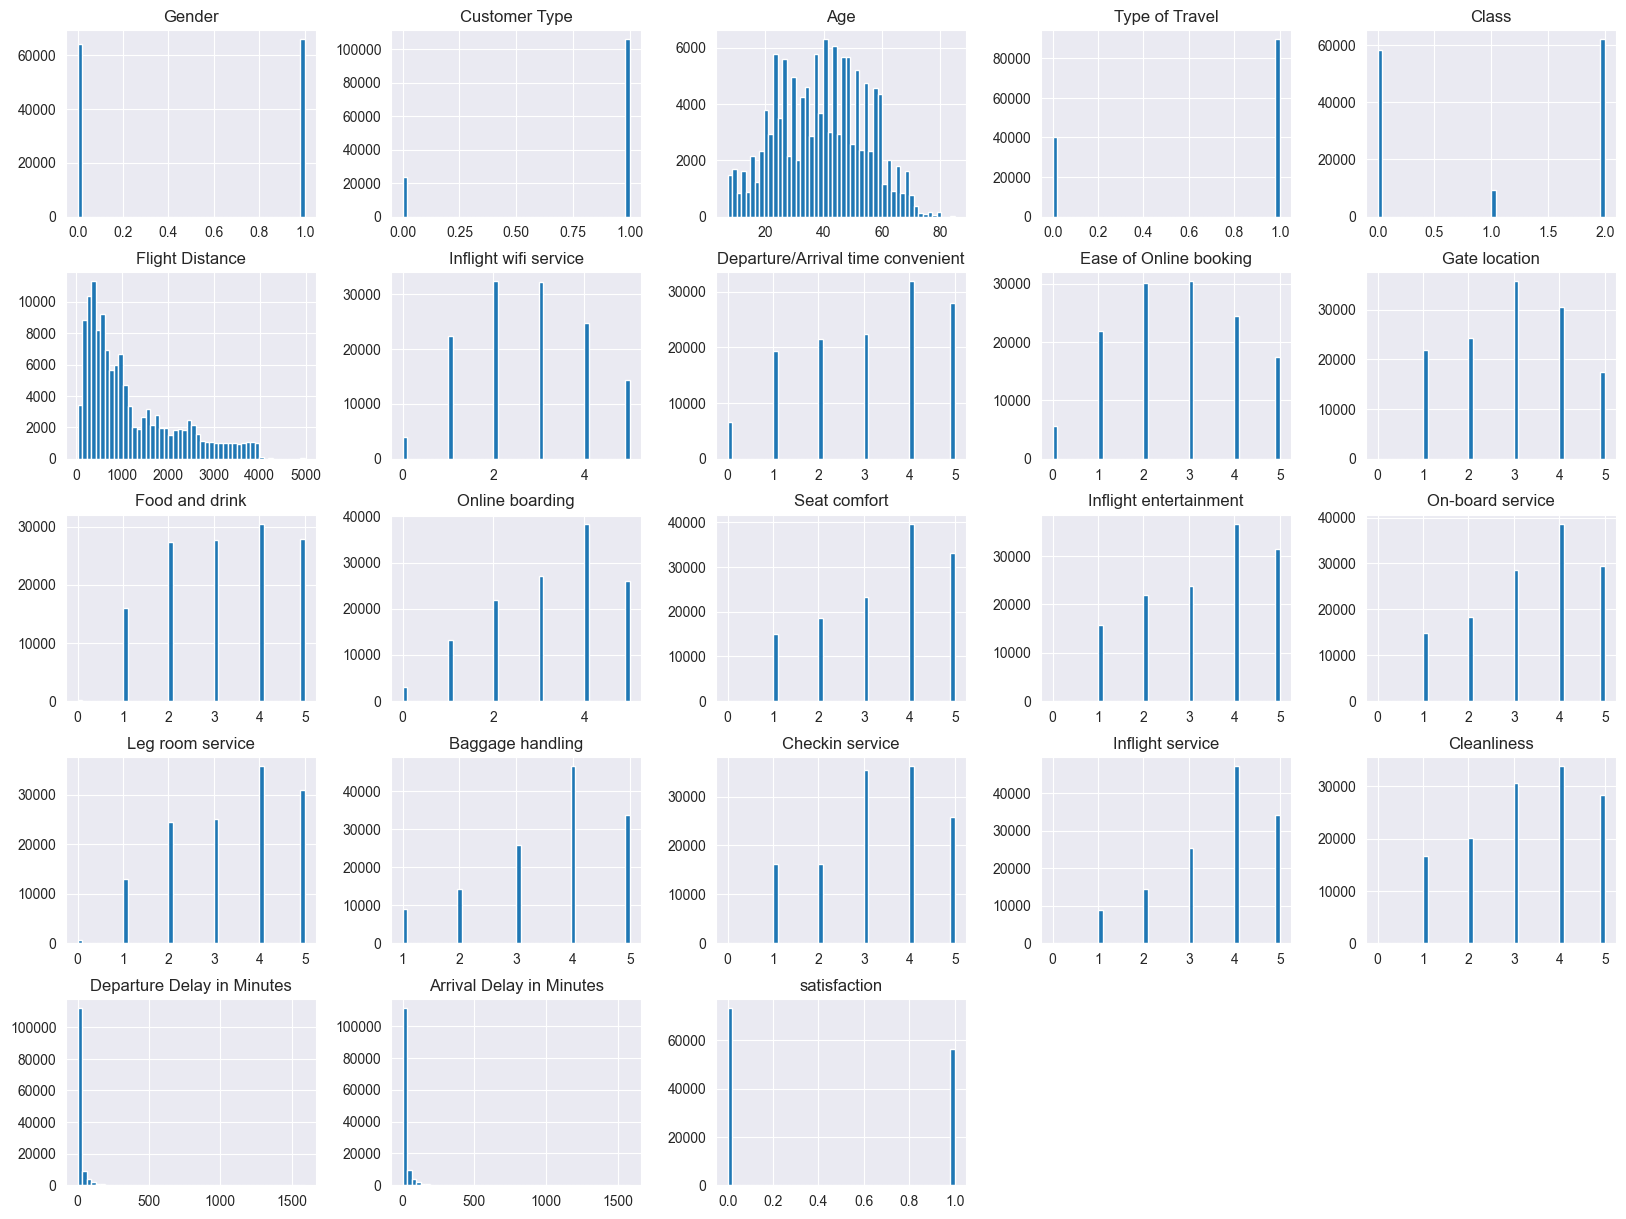

In [9]:
warnings.filterwarnings('ignore')
fulldf.hist(bins=50, figsize=(20,15))
plt.show()

### Dealing with NaN values
Below, we list the records which have NaN values in any cell. As we know from before, the only attribute that has NaN values is "Arrival Delay in Minutes", so all the records listed below have the value of that attribute as NaN. We do not know whether the values are NaN due to them being 0 (no delay) or due to some error - human or otherwise in the data, hence we do not know how to make the data valid without some assumptions.

In [10]:
fulldf[fulldf.isna().any(axis=1)]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
516,1,1,21,0,0,632,1,5,1,4,...,2,4,2,5,4,5,2,9,NaN,0
656,0,1,9,0,0,762,2,5,2,2,...,4,2,5,2,5,2,4,51,NaN,0
1071,0,0,25,1,0,1017,3,4,4,5,...,5,2,5,2,3,2,5,126,NaN,0
1224,0,1,7,0,0,399,4,5,4,4,...,4,4,3,1,1,4,4,0,NaN,0
1589,1,1,58,1,0,129,5,3,3,3,...,5,5,5,5,3,5,5,3,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128043,0,1,49,0,1,1249,2,5,2,3,...,3,4,5,4,3,4,3,230,NaN,0
128360,0,1,58,1,0,733,3,3,3,3,...,3,3,1,2,4,2,3,55,NaN,0
128528,1,0,29,1,0,1107,2,1,1,1,...,5,4,1,5,5,3,5,0,NaN,0
128936,0,1,58,1,0,1088,4,4,1,1,...,5,1,5,5,5,3,5,0,NaN,1


The table below represents the linear correlations between the attributes. The values range between -1 and 1, where positive values represent positive relations ("as X increases, Y increases"), while negative value represent negative relations ("as X increases, Y decreases"). Every attribute naturally has a linear relation with itself (1.0000). A final thing to note is that the table presented has many duplicates (we could remove the upper right triangle (if the table were cut diagonally from the upper-left corner to the lower-right corner), and not lose any data).<br>

<Axes: >

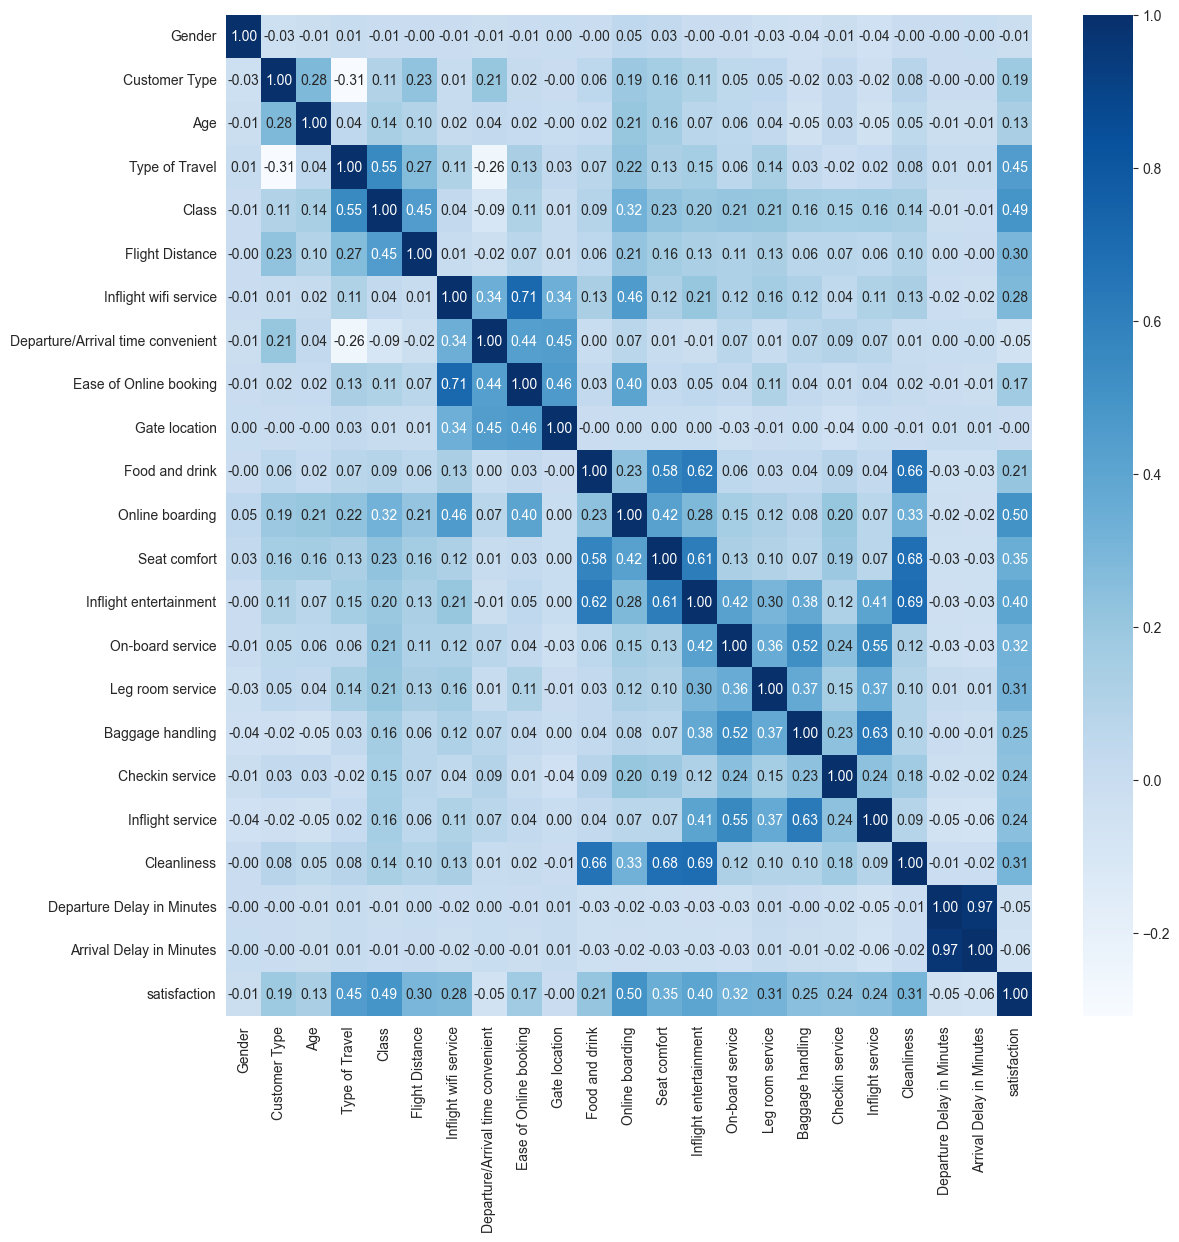

In [11]:
plt.figure(figsize=(13,13))
sns.heatmap(fulldf.corr(), cmap = 'Blues', annot=True, fmt=".2f")

We can see from the correlation function above that the attributes "Arrival Delay in Minutes" and "Departure Delay in Minutes" have an extremely high linear correlation (0.9653), and, since one of them has NaN values and the other doesn't, we shall remove the feature which has the NaN values from the dataframe in general.

In [12]:
fulldf = fulldf.drop(['Arrival Delay in Minutes'], axis = 1)

In [13]:
fulldf.info() #Presenting the final dataset info before machine learning algorithms for future reference

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   Gender                             129880 non-null  int64
 1   Customer Type                      129880 non-null  int64
 2   Age                                129880 non-null  int64
 3   Type of Travel                     129880 non-null  int64
 4   Class                              129880 non-null  int64
 5   Flight Distance                    129880 non-null  int64
 6   Inflight wifi service              129880 non-null  int64
 7   Departure/Arrival time convenient  129880 non-null  int64
 8   Ease of Online booking             129880 non-null  int64
 9   Gate location                      129880 non-null  int64
 10  Food and drink                     129880 non-null  int64
 11  Online boarding                    129880 non-null  int64
 12  Se

One last thing we must do before we split the data into train and test sets, we must normalize the values. As all are values are now numerical, and there are no NaN values, we can do that without too much trouble. <br>

In [14]:
x = fulldf.drop(['satisfaction'], axis = 1)
y = fulldf['satisfaction']

Next, we use the function min_max_scaler.fit_transform() to achieve normalization of the data.

In [15]:
z = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
x = pd.DataFrame(z_scaled)
x

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,1.0,0.576923,1.0,0.0,0.026050,1.0,0.8,0.6,0.8,...,0.8,0.6,1.0,1.0,1.0,1.00,0.4,1.0,1.0,0.031407
1,1.0,1.0,0.371795,1.0,1.0,0.571890,0.2,0.2,0.6,0.2,...,0.8,1.0,0.8,0.8,0.8,0.75,0.6,0.8,1.0,0.000000
2,0.0,0.0,0.166667,1.0,0.0,0.032512,0.4,0.0,0.4,0.8,...,0.4,0.4,0.4,0.8,0.2,0.50,0.4,0.4,0.4,0.000000
3,0.0,1.0,0.474359,1.0,1.0,0.675687,0.0,0.0,0.0,0.4,...,0.8,0.8,0.2,0.2,0.2,0.00,0.6,0.2,0.8,0.000000
4,1.0,1.0,0.538462,1.0,0.0,0.232431,0.4,0.6,0.8,0.6,...,0.2,0.4,0.4,0.4,0.4,0.25,0.8,0.4,0.8,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1.0,0.0,0.205128,1.0,0.0,0.032512,0.4,0.2,0.4,0.6,...,0.4,0.4,0.4,0.6,0.2,0.75,0.4,0.6,0.4,0.001884
129876,0.0,1.0,0.538462,1.0,1.0,0.467690,0.8,0.8,0.8,0.8,...,0.8,1.0,1.0,1.0,1.0,1.00,1.0,1.0,0.8,0.000000
129877,0.0,0.0,0.294872,1.0,1.0,0.396607,0.2,0.2,0.2,0.6,...,0.2,1.0,0.8,0.6,0.4,0.75,1.0,1.0,0.8,0.004397
129878,1.0,0.0,0.192308,1.0,0.0,0.195679,0.2,0.2,0.2,1.0,...,0.2,0.2,0.2,0.8,1.0,0.00,1.0,0.8,0.2,0.000000


## Models
Now that we are finished with data cleaning, we have a dataset, where there are no NaN values, all attributes are numerical and normalized, we can split the data using the train_test_split() method.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

### Dummy Classifier

Now that we have split our data, we can get down to the models. Before choosing and applying the models to the data, we need a baseline model, to compare all others to it: if the models thereafter are worse than the base model, we are doing something wrong. If the model is better than the base model, on the other hand, it means that the model works, and can be better at predicting than a "dummy" model. The base model we will use is "Dummy Classifier", which will, regardless of the input, put in the most frequent value in y_train. It puts in the most frequent value due to the strategy we have put into the model.<br><br>

after using the model.fit() and model.predict() methods, we can use the metrics.accuracy_score() method to test a see which percentage of the predictions made by the dummy classifier were correct. in our case, the percentage of correct answers is 56%.<br><br>

Alongside the accuracy, the time taken for the model to complete the training is printed, along with the confusion matrix to better understand the results. 

In [17]:
start_timeDummy = time.time()
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train, y_train)
predictionsDummy = dummyModel.predict(X_test)
accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
print("Accuracy (Dummy): ", accuracyDummy)
timeDummy = time.time() - start_timeDummy
print("Time taken to achieve result: %s seconds" % timeDummy)

Accuracy (Dummy):  0.5637511549122267
Time taken to achieve result: 0.005053520202636719 seconds


<Axes: >

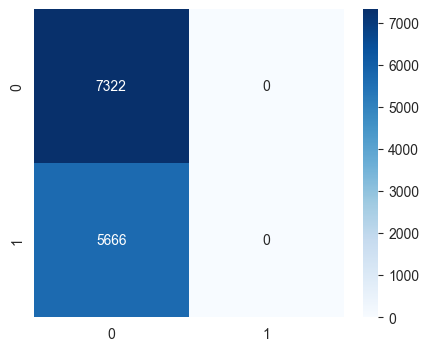

In [18]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')

### KNN: K Nearest Neighbor

Now we can start applying a model to the data that does something more than the dummy classifier. We will first use the KNN model. The KNN model (K nearest Neighbors) is one that chooses the value closest to the values from the train set. if K = 1, then it chooses depending on the single closest neighbor to the wanted data; if N > 1, then it chooses the label depending on the N closest neighbors (in terms of data). The "weights" parameter specifies whether the model is to give a higher penalty for the neighbors further away or to count their value as equally valuable to determine the label.<br><br>

A classification report is printed to the console alongside the confusion matrix and the accuracy, which presents the other metrics of evaluation such as precision, recall and F1-score.

In [19]:
start_timeKNN = time.time()
modelKNN = KNeighborsClassifier(n_neighbors = 9, weights='distance')
modelKNN.fit(X_train, y_train)
predictionsKNN = modelKNN.predict(X_test)
accuracyKNN = metrics.accuracy_score(y_test, predictionsKNN) #Resturns the same value as the score() method in the
print("Accuracy (KNN): ", accuracyKNN)
timeKNN = time.time() - start_timeKNN
print("Time taken to achieve result: %s seconds" % timeKNN)

Accuracy (KNN):  0.9337080381890976
Time taken to achieve result: 1.3586149215698242 seconds


<Axes: >

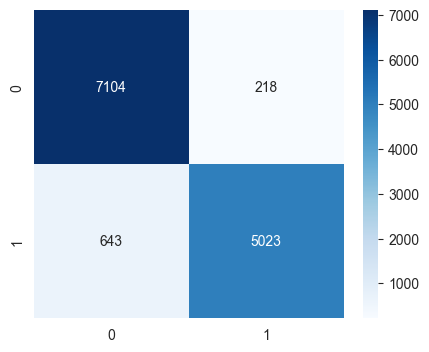

In [20]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsKNN), cmap = "Blues", annot=True, fmt = '.0f')

In [21]:
print(classification_report(y_test, predictionsKNN))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7322
           1       0.96      0.89      0.92      5666

    accuracy                           0.93     12988
   macro avg       0.94      0.93      0.93     12988
weighted avg       0.94      0.93      0.93     12988



### Logistic Regression

For our second model we will choose Logistic Regression. This classifier is fairly simple, and yet works well with many datasets.

In [22]:
start_timeLogReg = time.time()
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train, y_train)
predictionsLogReg = modelLogReg.predict(X_test)
accuracyLogReg = modelLogReg.score(X_test, y_test)
print("Accuracy (Logistic Regression): ", accuracyLogReg)
timeLogReg = time.time() - start_timeLogReg
print("Time taken to achieve result: %s seconds" % timeLogReg)

Accuracy (Logistic Regression):  0.8733446258084385
Time taken to achieve result: 0.2704427242279053 seconds


<Axes: >

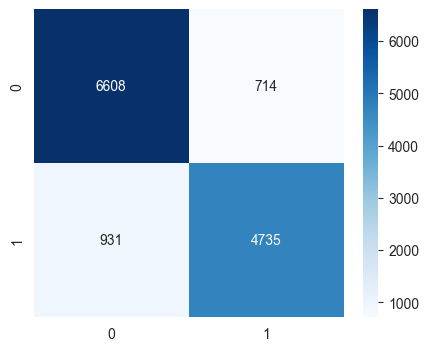

In [23]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')

In [24]:
print(classification_report(y_test, predictionsLogReg))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7322
           1       0.87      0.84      0.85      5666

    accuracy                           0.87     12988
   macro avg       0.87      0.87      0.87     12988
weighted avg       0.87      0.87      0.87     12988



### Gaussian Naive Bayes

This classifier uses the Gaussian distribution to help it classify records. By calculating the likelihoods for each feature on whether it is of one class or another, and multiplying these likelihoods for all classes (in our case 2).

In [25]:
#Gaussian Naive Bayes
start_timeGaussianNB = time.time()
modelGNB = GaussianNB()
modelGNB.fit(X_train, y_train)
predictionsGNB = modelGNB.predict(X_test)
accuracyGNB = metrics.accuracy_score(y_test, predictionsGNB)
print("Accuracy (XGBoost): ", accuracyGNB)
timeGNB = time.time() - start_timeGaussianNB
print("Time taken to achieve result: %s seconds" % timeGNB)

Accuracy (XGBoost):  0.8645672928857406
Time taken to achieve result: 0.04983067512512207 seconds


<Axes: >

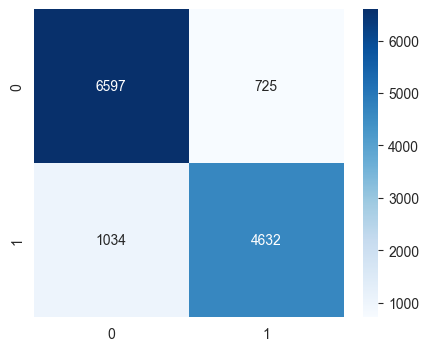

In [26]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsGNB), cmap = "Blues", annot=True, fmt = '.0f')

In [27]:
print(classification_report(y_test, predictionsGNB))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      7322
           1       0.86      0.82      0.84      5666

    accuracy                           0.86     12988
   macro avg       0.86      0.86      0.86     12988
weighted avg       0.86      0.86      0.86     12988



### Random Forests

Next, we can check the accuracy received when using the <b>Random Forests Classifier</b>. This classifier uses ensemble learning by constructing a multitude of decision trees (specified with the n_estimators hyperparameter), without a maximum depth of each tree (such depth can be added using the max_depth hyperparameter, but after several tests, the result was that not limiting the trees is best in the case of this data). After several tests, the number of estimators was set to 500, as the best balance between time and resource consumption.<br>
For the test set, each trees prediction is calculated, the results then aggregated, and the final answer is given. The aggregation is performed by each trees result counted and the "majority vote" is the final answer of the classifier.

In [28]:
#Random Forests
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0)
modelRandForests.fit(X_train, y_train)
predictionsRandForests = modelRandForests.predict(X_test)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achieve result: %s seconds" % timeRandForests)

Accuracy (Random Forests):  0.9633507853403142
Time taken to achieve result: 11.458495855331421 seconds


<Axes: >

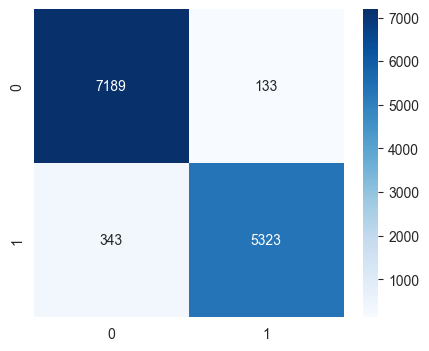

In [29]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')

In [30]:
print(classification_report(y_test, predictionsRandForests))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7322
           1       0.98      0.94      0.96      5666

    accuracy                           0.96     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.96      0.96      0.96     12988



### AdaBoost

Next, we will check the performance of the <b>AdaBoost Classifier</b> (AdaBoost stands for Adaptive Boost). This classifier also uses ensemble learning to achieve its purpose. After receiving the results from some base classifier, in our case the Decision Tree Classifier, the model then performs the base classifier over and over (n_estimator times), while each time giving more weight to the misclassified training instances. Then, again using ensemble learning techniques the model returns its final answer according to the many sub-models it created.

In [42]:
#AdaBoost
start_timeAdaBoost = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 1000, random_state = 0, learning_rate = 0.1)
modelAdaBoost.fit(X_train, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achieve result: %s seconds" % timeAdaBoost)

Accuracy (AdaBoost):  0.9499538035109332
Time taken to achieve result: 114.30647778511047 seconds


<Axes: >

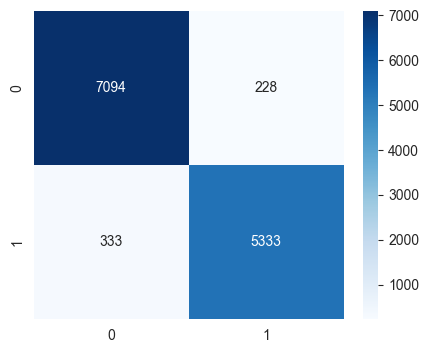

In [32]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')

In [33]:
print(classification_report(y_test, predictionsAdaBoost))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7322
           1       0.96      0.94      0.95      5666

    accuracy                           0.96     12988
   macro avg       0.96      0.96      0.96     12988
weighted avg       0.96      0.96      0.96     12988



### XGBoost

Last of the single models (but certainly not least), we shall run the <b>XGBoost Classifier</b> on our data (XGBoost standing for Extreme Gradient Boosting), which uses Ensemble Learning and boosting in a similar yet different way to AdaBoost above. Where AdaBoost tweaks the individual instance weights, giving some more or less weight, XGBoost fits a new predictor to the residual errors made by the previous predictor. It should be noted that the residual errors get smaller with each iteration of XGBoost, making the model very effective.

In [34]:
#XGBoost
start_timeXGBoost = time.time()
warnings.filterwarnings('ignore')
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 200, verbosity = 0, use_label_encoder = False, n_jobs = -1)
modelXGBoost.fit(X_train, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achieve result: %s seconds" % timeXGBoost)

Accuracy (XGBoost):  0.9645826917154297
Time taken to achieve result: 0.6811110973358154 seconds


<Axes: >

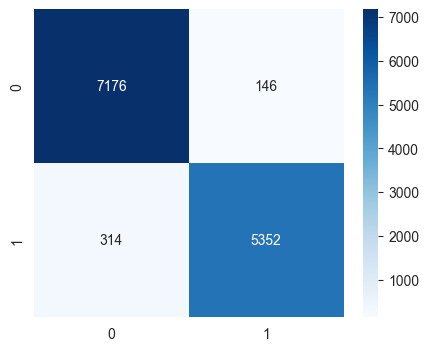

In [35]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

In [36]:
print(classification_report(y_test, predictionsXGBoost))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7322
           1       0.97      0.94      0.96      5666

    accuracy                           0.96     12988
   macro avg       0.97      0.96      0.96     12988
weighted avg       0.96      0.96      0.96     12988



We will create a table, that will compare the classifiers which were run on this data, their runtimes and accuracies (other parameters not presented for the sake of readability).

In [43]:
results = pd.DataFrame(np.array([['Dummy', accuracyDummy, timeDummy],
                            ['KNN', accuracyKNN, timeKNN],
                            ['Logistic Regression', accuracyLogReg, timeLogReg],
                            ['Gaussian Naive Bayes', accuracyGNB, timeGNB],
                            ['Random Forests', accuracyRandForests, timeRandForests],
                            ['AdaBoost', accuracyAdaBoost, timeAdaBoost],
                            ['XGBoost', accuracyXGBoost, timeXGBoost]]),
                  columns=['Model', 'Accuracy', 'Runtime (Seconds)'])
resultsView = results.style.set_properties(**{'text-align': 'left'})
resultsView

,Model,Accuracy,Runtime (Seconds)
0,Dummy,0.5637511549122267,0.005053520202636719
1,KNN,0.9337080381890976,1.3586149215698242
2,Logistic Regression,0.8733446258084385,0.2704427242279053
3,Gaussian Naive Bayes,0.8645672928857406,0.04983067512512207
4,Random Forests,0.9633507853403142,11.458495855331421
5,AdaBoost,0.9499538035109332,114.30647778511047
6,XGBoost,0.9645826917154297,0.6811110973358154


We will plot a bar graph to help us see the accuracies better. Again, the differences here are minor, so the graph is of limited use. We can determine that the Dummy Classifier and Logistic Regression perform much worse than the rest. 

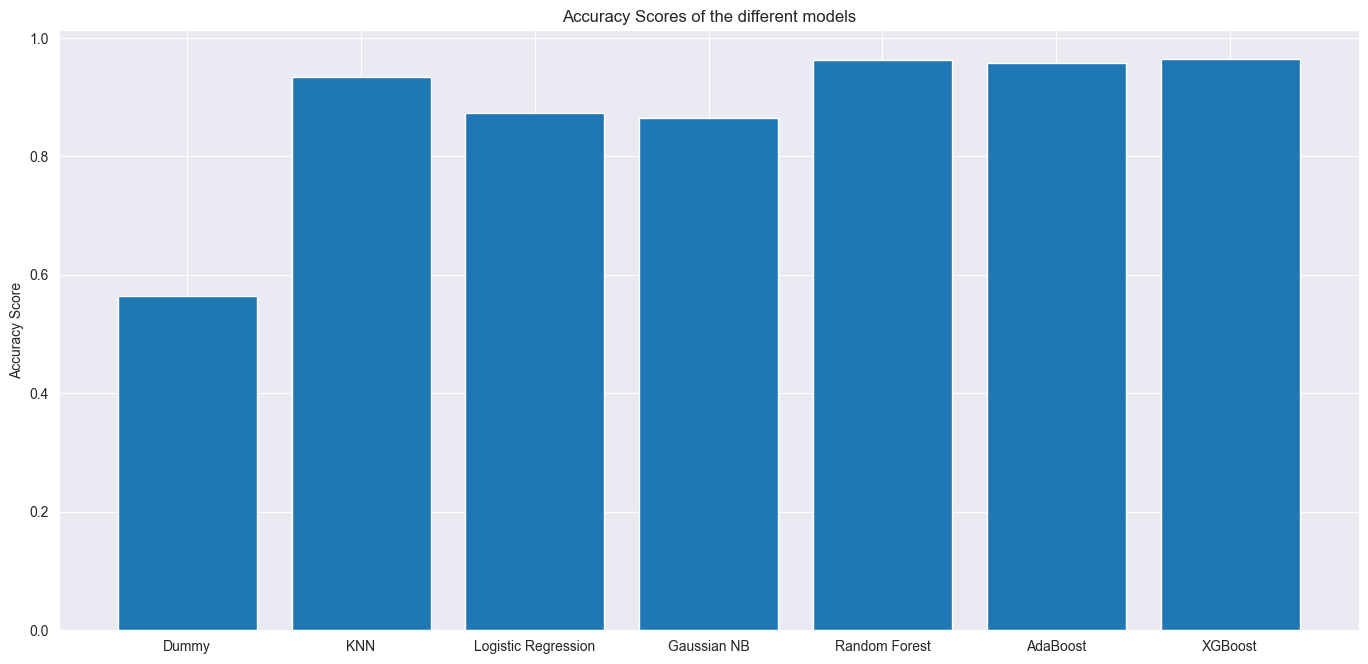

In [38]:
fig = plt.figure(figsize=(13,6))

accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyGNB, accuracyRandForests, accuracyAdaBoost, accuracyXGBoost]
axes = fig.add_axes([0,0,1,1])
axes.bar(['Dummy', 'KNN', 'Logistic Regression', 'Gaussian NB', 'Random Forest', 'AdaBoost', 'XGBoost'], accuracies)
axes.set_ylabel("Accuracy Score")
axes.set_title("Accuracy Scores of the different models")
plt.rcParams['xtick.labelsize'] = 9

In the graph below, we try to zoom in the graph above (by limiting the y-axis). As we can see, most of the classifiers are not in the range specified, hence invisible in the graph.

(0.957, 0.9664)

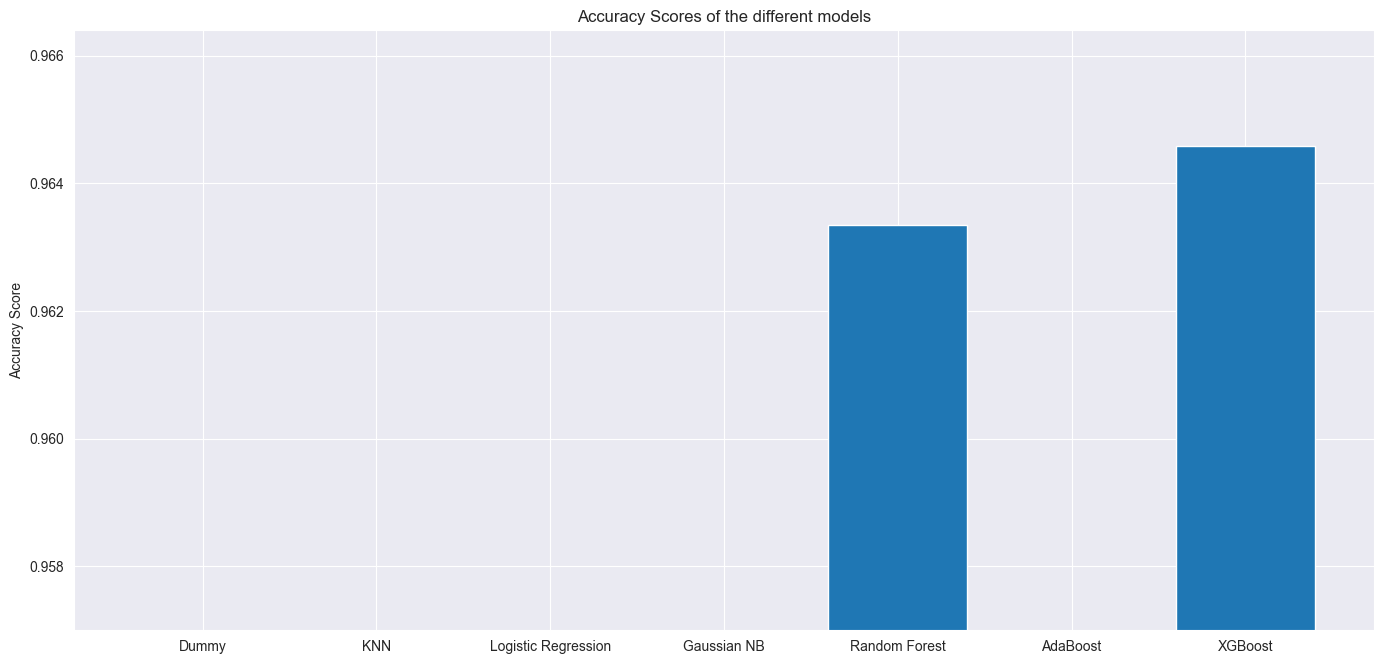

In [44]:
fig = plt.figure(figsize=(13,6))

accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyGNB, accuracyRandForests, accuracyAdaBoost,
              accuracyXGBoost]
axes = fig.add_axes([0,0,1,1])
axes.bar(['Dummy', 'KNN', 'Logistic Regression', 'Gaussian NB', 'Random Forest', 'AdaBoost', 'XGBoost'], accuracies)
axes.set_ylabel("Accuracy Score")
axes.set_title("Accuracy Scores of the different models")
plt.rcParams['xtick.labelsize'] = 9
axes.set_ylim([0.957, 0.9664])

Next, The bar graph for the runtimes is shown.

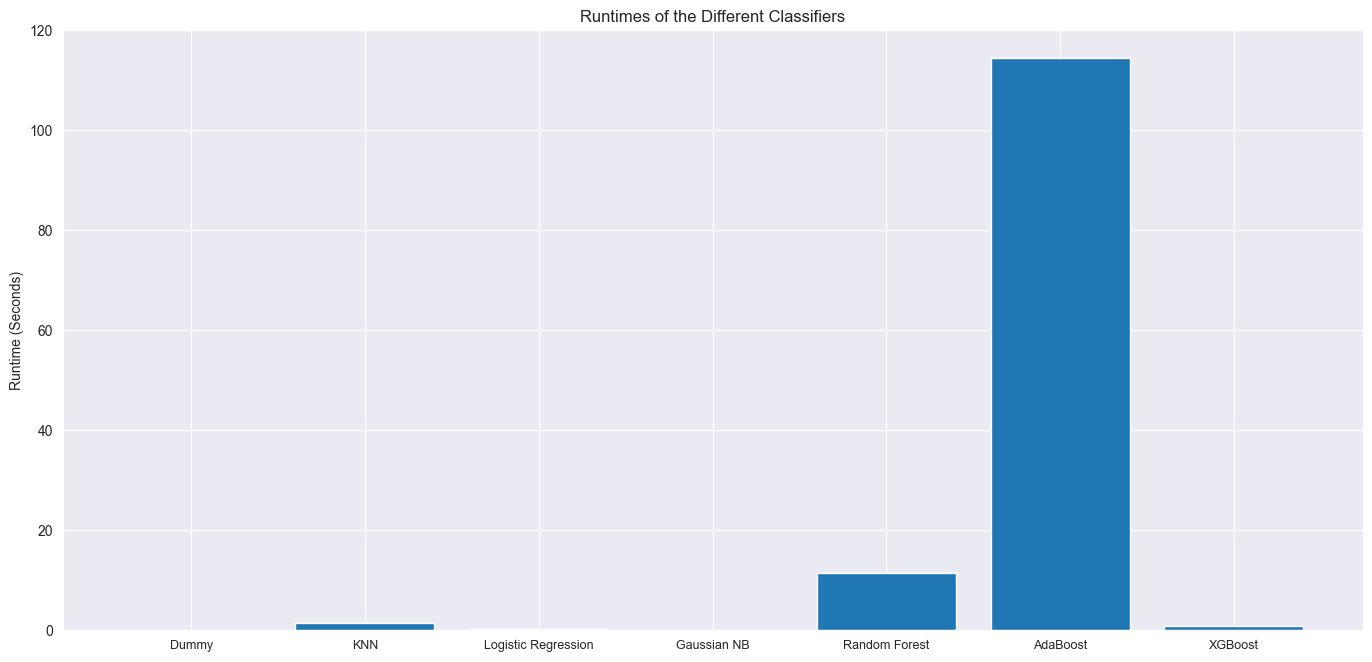

In [45]:
def timeGraph():
    fig = plt.figure(figsize=(13,6))

    time = [timeDummy, timeKNN, timeLogReg, timeGNB, timeRandForests, timeAdaBoost, timeXGBoost]
    timeSize = np.arange(len(time))
    axes = fig.add_axes([0,0,1,1])
    labels = ['Dummy', 'KNN', 'Logistic Regression','Gaussian NB', 'Random Forest', 'AdaBoost', 'XGBoost']
    axes.bar(labels, time)
    axes.set_ylabel("Runtime (Seconds)")
    axes.set_title("Runtimes of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 10
    
timeGraph()

In [46]:
resultsView

,Model,Accuracy,Runtime (Seconds)
0,Dummy,0.5637511549122267,0.005053520202636719
1,KNN,0.9337080381890976,1.3586149215698242
2,Logistic Regression,0.8733446258084385,0.2704427242279053
3,Gaussian Naive Bayes,0.8645672928857406,0.04983067512512207
4,Random Forests,0.9633507853403142,11.458495855331421
5,AdaBoost,0.9499538035109332,114.30647778511047
6,XGBoost,0.9645826917154297,0.6811110973358154


## Conclusion

Now that we have determined the most accurate classifier, we can have a look at the runtimes of each classifier. We can see that the XGBoost classifier produces the best accuracy while taking less than a second to achieve the results. 

Throughout the data and the notebook, we have tried to find the best model for our data, with the objectives to optimize accuracy and runtime as best we can. We have tried many classifiers, the results of which are displayed above. We can conclude that the XGBoost classifier with the corrected hyperparameters is the best classifier of the ones we have reviewed.<br>

Moreover, the Confusion Matrices presented throughout the notebook have determined that, considering the data was not equally balanced to begin with, the classifiers are not overly biased (roughly the same percentage of errors for both classes).